In [16]:
#   215 = RB F1 Team
DRIVER_LS = {1:0,4:0,807:0,815:1,817:1,822:1,825:1,830:0,832:1,839:1,840:1,842:0,844:0,846:0,847:1,848:0,852:0,855:0,857:1,858:2,859:2,860:2,861:1,862:2}
DRIVER_C = {1:"#00CACA",4:"#2E8B57",807:"#191919",815:"#0000B0",817:"#7B68EE",822:"#00FF00",825:"#191919",830:"#0000B0",832:"#FF0000",839:"#FF69B4",840:"#2E8B57",842:"#FF69B4",844:"#FF0000",846:"#FE7F00",847:"#00CACA",848:"#007FFE",852:"#7B68EE",855:"#00FF00",857:"#FE7F00",858:"#007FFE",859:"#7B68EE",860:"#191919",861:"#007FFE",862:"#FF69B4"}
TEAM_C = {1:"#FE7F00",3:"#007FFE",6:"#FF0000",9:"#0000B0",15:"#00FF00",117:"#2E8B57",131:"#00CACA",210:"#191919",214:"#FF69B4",215:"#7B68EE"}
LINESTYLES = ['-', '-.', '--', ':', '-', '-']

from IPython.display import HTML, display
HTML("""<div id="contents"></div>
<script>
function fill_toc() {
  l = document.querySelectorAll("h2[id^=race]")
  src = '<h2 id="index-races">Races</h2>'
  for (const e of l) src += `<li><a href="#${e.id}">${e.textContent}</a>`;
  document.querySelector("#contents").innerHTML = src;
}
</script>""")

In [17]:
import base64, io, json, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from collections import Counter


def read_csv(name, **kwargs):
    df = pd.read_csv(f'data/{name}', na_values=r'\N', **kwargs)
    return df


# create replacement raceId that is ordered by time
def race_key(race_year, race_round):
    # My bet: we won't get to 100 races per year :)
    return (race_year * 100) + race_round

def races_subset(df, race_ids):
    df = df[df.raceId.isin(race_ids)].copy()
    df = df.join(races[['round', 'raceKey']], on='raceId')
    df['round'] -= df['round'].min()
    # drop_duplicates: duplicate entries have appeared in 2021
    # race:1051 driver:832
    return df.set_index('round').sort_index().drop_duplicates()

def add_lap_0(df):
    copy = df.T
    copy.insert(0, 0, 0)
    return copy.T

def driver_tag(driver_df_row):
    return ('<a href="{url}" title="Number: {number:.0f}\n'
            'Nationality: {nationality}">{Driver}</a>').format(**driver_df_row)

def constructor_tag(constructor_df_row):
    return ('<a href="{url}" title="Nationality: {nationality}">'
            '{name}</a>').format(**constructor_df_row)



RACE_COLS = ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url']


YEAR = 2024
# Read data
circuits = read_csv('circuits.csv', index_col=0)
constructorResults = read_csv('constructor_results.csv', index_col=0)
constructors = read_csv('constructors.csv', index_col=0)
constructorStandings = read_csv('constructor_standings.csv', index_col=0)
drivers = read_csv('drivers.csv', index_col=0)
driverStandings = read_csv('driver_standings.csv', index_col=0)
lapTimes = read_csv('lap_times.csv')
pitStops = read_csv('pit_stops.csv')
qualifying = read_csv('qualifying.csv', index_col=0)
races = read_csv('races.csv', index_col='raceId', usecols=RACE_COLS)
results = read_csv('results.csv', index_col=0)
seasons = read_csv('seasons.csv', index_col=0)
status = read_csv('status.csv', index_col=0)


# To sequence the races if they did not happen in order of raceId (ie. 2021)
races['raceKey'] = race_key(races['year'], races['round'])

# For display in HTML tables
drivers['display'] = drivers.surname
drivers['Driver'] = drivers['forename'] + " " + drivers['surname']
drivers['Driver'] = drivers.apply(driver_tag, axis=1)
constructors['label'] = constructors['name']
constructors['name'] = constructors.apply(constructor_tag, axis=1)

# Join fields
results['status'] = results.statusId.map(status.status)
results['Team'] = results.constructorId.map(constructors.name)
results['score'] = results.points>0
results['podium'] = results.position<=3

# Cut data to one year
# was using numexpr here but 2.8.5 breaks pandas:
# https://github.com/pandas-dev/pandas/issues/54449
races = races.loc[races.year==YEAR].sort_values('round').copy()
results = results[results.raceId.isin(races.index)].copy()
lapTimes = lapTimes[lapTimes.raceId.isin(races.index)].copy()
# Save Ids of races that have actually happened (i.e. have valid lap-times).
race_ids = np.unique(lapTimes.raceId)
driverStandings = races_subset(driverStandings, race_ids)
constructorStandings = races_subset(constructorStandings, race_ids)

# Sprint results (2021 onwards)
if os.path.isfile('../input/formula-1-race-data/sprint_results.csv'):
    sprint_results = pd.read_csv('../input/formula-1-race-data/sprint_results.csv', na_values=r'\N')
    sprint_results = sprint_results[sprint_results.raceId.isin(races.index)].copy()

lapTimes = lapTimes.merge(results[['raceId', 'driverId', 'positionOrder']], on=['raceId', 'driverId'])
lapTimes['seconds'] = lapTimes.pop('milliseconds') / 1000

def formatter(v):
    if type(v) is str:
        return v
    if pd.isna(v) or v <= 0:
        return ''
    if v == int(v):
        return f'{v:.0f}'
    return f'{v:.1f}'

def table_html(table, caption):
    return (f'<h3>{caption}</h3>' +
            table.style.format(formatter).to_html())

# Processing for Drivers & Constructors championship tables
def format_standings(df, key):
    df = df.sort_values('position')
    gb = results.groupby(key)
    df['Position'] = df.positionText
    df['scores'] = gb.score.sum()
    df['podiums'] = gb.podium.sum()
    return df

# Drivers championship table
def drivers_standings(df):
    index = 'driverId'
    df = df.set_index(index)
    df = df.join(drivers)
    df = format_standings(df, index)
    df['Team'] = results.groupby(index).Team.last()
    use = ['Position', 'Driver',  'Team', 'points', 'wins', 'podiums', 'scores', 'nationality' ]
    df = df[use].set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Constructors championship table
def constructors_standings(df):
    index = 'constructorId'
    df = df.set_index(index)
    df = df.join(constructors)
    df = format_standings(df, index)
    
    # add drivers for team
    tmp = results.join(drivers.drop(labels="number", axis=1), on='driverId')
    df = df.join(tmp.groupby(index).Driver.unique().str.join(', ').to_frame('Drivers'))

    use = ['Position', 'name', 'points', 'wins', 'podiums', 'scores', 'nationality', 'Drivers' ]
    df = df[use].set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Race results table
def format_results(df):
    df['Team'] = df.constructorId.map(constructors.name)
    df['Position'] = df.positionOrder
    use = ['Driver', 'Team', 'grid', 'Position', 'points', 'laps', 'time', 'status' ]
    df = df[use].sort_values('Position')
    df = df.set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Return the HTML img tag for a plot - allows us to set an alt tag for the image
# Added for accessibility and to fix warning:
# [NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
def render_plot(title, alt_txt):
    fig = plt.gcf()
    fig.set_facecolor('white')
    buf = io.BytesIO()
    metadata = {'Title': title,
                'Author': 'James Trotman',
                'Source': f'https://www.kaggle.com/code/jtrotman/f1-race-traces-{YEAR}'}
    fig.savefig(buf, format='png', bbox_inches='tight', metadata=metadata)
    plt.close()
    b64 = base64.b64encode(buf.getvalue()).decode()
    return '<img alt="%s" src="data:image/png;base64,%s">' % (alt_txt, b64)

In [18]:
results

raceId  driverId  constructorId  number  grid  position  \
resultId                                                            
26286       1121       830              9     1.0     1       1.0   
26287       1121       815              9    11.0     5       2.0   
26288       1121       832              6    55.0     4       3.0   
26289       1121       844              6    16.0     2       4.0   
26290       1121       847            131    63.0     3       5.0   
...          ...       ...            ...     ...   ...       ...   
26760       1144       825            210    20.0    14      16.0   
26761       1144       859            215    30.0    12      17.0   
26762       1144       822             15    77.0     9       NaN   
26763       1144       861              3    43.0    20       NaN   
26764       1144       815              9    11.0    10       NaN   

         positionText  positionOrder  points  laps  ... milliseconds  \
resultId                                            ...                
26286               1              1    26.0    57  ...    5504742.0   
26287               2              2    18.0    57  ...    5527199.0   
26288               3              3    15.0    57  ...    5529852.0   
26289               4              4    12.0    57  ...    5544411.0   
26290               5              5    10.0    57  ...    5551530.0   
...               ...            ...     ...   ...  ...          ...   
26760              16             16     0.0    57  ...          NaN   
26761              17             17     0.0    55  ...          NaN   
26762               R             18     0.0    30  ...          NaN   
26763               R             19     0.0    26  ...          NaN   
26764               R             20     0.0     0  ...          NaN   

          fastestLap  rank  fastestLapTime fastestLapSpeed  statusId  \
resultId                                                               
26286           39.0   1.0        1:32.608         210.383         1   
26287           40.0   4.0        1:34.364         206.468         1   
26288           44.0   6.0        1:34.507         206.156         1   
26289           36.0   2.0        1:34.090         207.069         1   
26290           40.0  12.0        1:35.065         204.946         1   
...              ...   ...             ...             ...       ...   
26760           57.0   1.0        1:25.637         222.002        11   
26761           52.0  12.0        1:28.751         214.212         5   
26762           14.0  19.0        1:29.482         212.462       130   
26763            5.0  17.0        1:29.411         212.631         5   
26764            NaN   0.0             NaN             NaN         4   

                    status                                               Team  \
resultId                                                                        
26286             Finished  <a href="http://en.wikipedia.org/wiki/Red_Bull...   
26287             Finished  <a href="http://en.wikipedia.org/wiki/Red_Bull...   
26288             Finished  <a href="http://en.wikipedia.org/wiki/Scuderia...   
26289             Finished  <a href="http://en.wikipedia.org/wiki/Scuderia...   
26290             Finished  <a href="http://en.wikipedia.org/wiki/Mercedes...   
...                    ...                                                ...   
26760               +1 Lap  <a href="http://en.wikipedia.org/wiki/Haas_F1_...   
26761               Engine  <a href="http://en.wikipedia.org/wiki/RB_Formu...   
26762     Collision damage  <a href="http://en.wikipedia.org/wiki/Sauber_M...   
26763               Engine  <a href="http://en.wikipedia.org/wiki/Williams...   
26764            Collision  <a href="http://en.wikipedia.org/wiki/Red_Bull...   

          score  podium  
resultId                 
26286      True    True  
26287      True    True  
26288      True    True  
26289      True   False  
26290      True   False  
..

In [19]:
driverStandings

raceId  driverId  points  position positionText  wins  raceKey
round                                                                
0        1121       839     0.0        17           17     0   202401
0        1121       858     0.0        20           20     0   202401
0        1121       822     0.0        19           19     0   202401
0        1121       842     0.0        18           18     0   202401
0        1121       830    26.0         1            1     1   202401
...       ...       ...     ...       ...          ...   ...      ...
23       1144       815   152.0         8            8     0   202424
23       1144       830   437.0         1            1     9   202424
23       1144       859     4.0        21           21     0   202424
23       1144       855     4.0        20           20     0   202424
23       1144       862     0.0        24           24     0   202424

[519 rows x 7 columns]


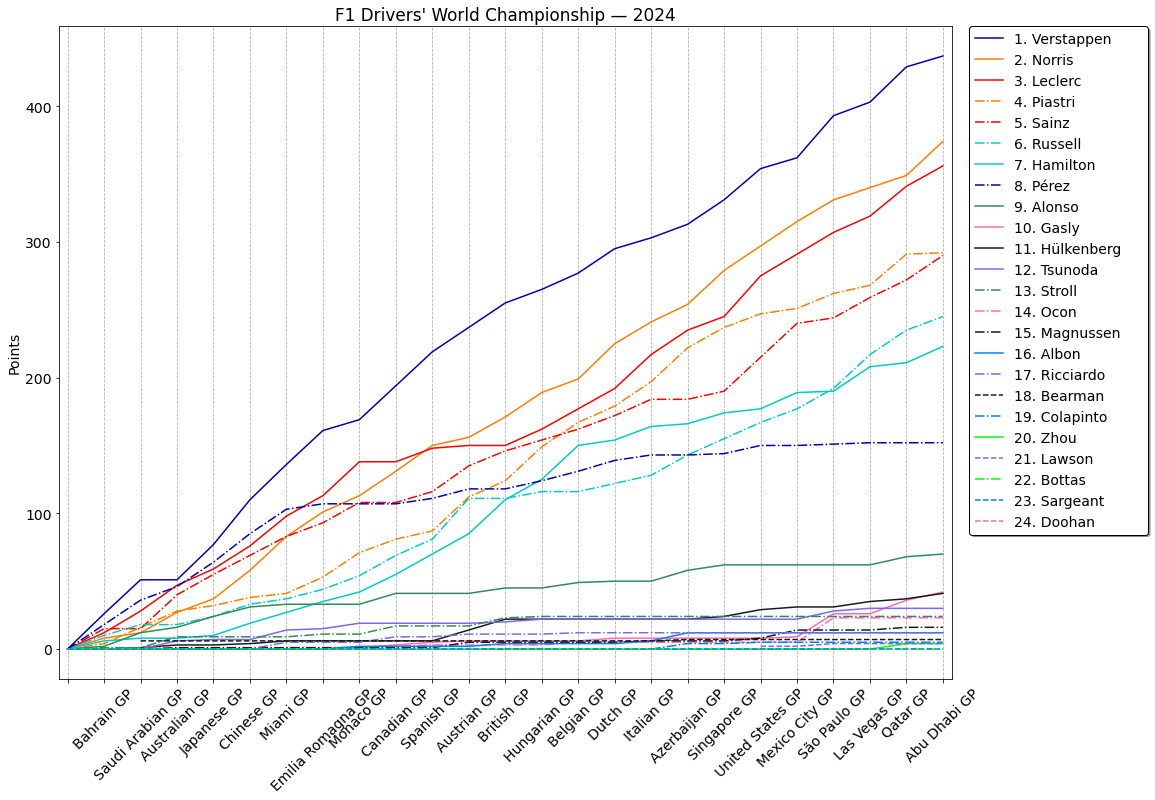

In [20]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=(14))
plt.rc("axes", xmargin=0.01)

# Championship position traces
champ = driverStandings[driverStandings.driverId.isin(DRIVER_C)].groupby("driverId").position.last().to_frame("Pos")
champ = champ.join(drivers)
order = np.argsort(champ.Pos)

color = [DRIVER_C[d] for d in champ.index[order]]
style = [LINESTYLES[DRIVER_LS[d]] for d in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.display

chart = driverStandings[driverStandings.driverId.isin(DRIVER_C)].pivot(index="raceKey", columns="driverId", values="points")
names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))

chart.iloc[:, order].plot(title=f"F1 Drivers\' World Championship — {YEAR}", color=color, style=style)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
legend_opts = dict(bbox_to_anchor=(1.02, 0, 0.2, 1),
                   loc="upper right",
                   ncol=1,
                   shadow=True,
                   edgecolor="black",
                   mode="expand",
                   borderaxespad=0.)
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Drivers\' World Championship &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Drivers\' World Championship - {YEAR}',
                f'Formula One Drivers\' World Championship - {YEAR}'),
    table_html(drivers_standings(driverStandings.loc[driverStandings.index.max()]), "Results")
]
HTML("\n".join(html_lines))

In [21]:
# Championship position traces
champ = constructorStandings.groupby("constructorId").position.last().to_frame("Pos")
champ = champ.join(constructors)
order = np.argsort(champ.Pos)

color = [TEAM_C[c] for c in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.label

chart = constructorStandings.pivot(index="raceKey", columns="constructorId", values="points")
names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))

chart.iloc[:, order].plot(title=f"F1 Constructors\' World Championship — {YEAR}", color=color)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Constructors\' World Championship &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Constructors\' World Championship - {YEAR}',
                f'Formula One Constructors\' World Championship - {YEAR}'),
    table_html(constructors_standings(constructorStandings.loc[constructorStandings.index.max()]), "Results")
]
HTML("\n".join(html_lines))

In [22]:
chart.diff().fillna(0).rolling(axis=0,window=5,min_periods=1).mean()

1. McLaren  9. Williams  2. Ferrari  3. Red Bull  \
                     0.000000          0.0    0.000000         0.00   
Bahrain GP           6.000000          0.0   13.500000        22.00   
Saudi Arabian GP     9.333333          0.0   16.333333        29.00   
Australian GP       13.750000          0.0   23.250000        24.25   
Japanese GP         13.800000          0.0   24.000000        28.20   
Chinese GP          19.200000          0.0   30.200000        39.00   
Miami GP            22.400000          0.0   32.000000        39.00   
Emilia Romagna GP   25.200000          0.0   32.600000        36.20   
Monaco GP           25.800000          0.4   31.800000        35.80   
Canadian GP         28.600000          0.4   26.400000        32.00   
Spanish GP          28.200000          0.4   23.800000        27.00   
Austrian GP         28.800000          0.4   20.800000        23.20   
British GP          28.200000          0.8   18.000000        21.00   
Hungarian GP        30.800000          0.4   14.000000        22.60   
Belgian GP          30.800000          0.4   18.600000        21.40   
Dutch GP            33.400000          0.4   20.000000        20.80   
Italian GP          34.000000          0.8   23.200000        18.20   
Azerbaijan GP       36.200000          2.4   24.600000        16.60   
Singapore GP        35.600000          2.4   23.800000        17.20   
United States GP    35.600000          2.6   30.200000        19.20   
Mexico City GP      32.400000          2.6   33.400000        15.60   
São Paulo GP        31.000000          2.2   30.000000        19.60   
Las Vegas GP        26.400000          0.2   31.800000        19.80   
Qatar GP            24.800000          0.2   35.600000        21.20   
Abu Dhabi GP        24.400000          0.0   31.200000        17.00   

                   10. Sauber  5. Aston Martin  4. Mercedes  7. Haas F1 Team  \
                          0.0         0.000000     0.000000         0.000000   
Bahrain GP                0.0         1.500000     8.000000         0.000000   
Saudi Arabian GP          0.0         4.333333     8.666667         0.333333   
Australian GP             0.0         6.250000     6.500000         1.000000   
Japanese GP               0.0         6.600000     6.800000         0.800000   
Chinese GP                0.0         8.000000    10.400000         1.000000   
Miami GP                  0.0         7.800000     9.600000         1.400000   
Emilia Romagna GP         0.0         6.200000    10.600000         1.200000   
Monaco GP                 0.0         3.800000    14.000000         0.600000   
Canadian GP               0.0         5.000000    18.000000         0.600000   
Spanish GP                0.0         3.600000    19.800000         0.400000   
Austrian GP               0.0         3.200000    26.400000         2.400000   
British GP                0.0         4.800000    28.400000         4.000000   
Hungarian GP              0.0         5.000000    29.000000         4.000000   
Belgian GP                0.0         3.000000    28.400000         4.000000   
Dutch GP                  0.0         3.200000    25.000000         4.000000   
Italian GP                0.0         3.200000    19.200000         1.800000   
Azerbaijan GP             0.0         2.800000    17.600000         0.400000   
Singapore GP              0.0         3.400000    17.600000         0.800000   
United States GP          0.0         2.600000    15.600000         2.200000   
Mexico City GP            0.0         2.400000    18.000000         3.800000   
São Paulo GP              0.0         2.400000    18.000000         3.600000   
Las Vegas GP              0.0         0.800000    23.200000         4.200000   
Qatar GP                  0.8         1.200000    23.400000         4.600000   
Abu Dhabi GP              0.8         1.600000    24.800000         4.000000   

                   6. Alpine F1 Team  8. RB F1 Team  
                                 0.0 

In [23]:
# Championship position traces
champ = constructorStandings.groupby("constructorId").position.last().to_frame("Pos")
champ = champ.join(constructors)
order = np.argsort(champ.Pos)

color = [TEAM_C[c] for c in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.label

chart = constructorStandings.pivot(index="raceKey", columns="constructorId", values="points")

names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
n_races = 5
chart = pd.concat(((row * 0).to_frame("").T, chart))
chart = chart.diff().rolling(axis=0,window=n_races,min_periods=1).mean()
chart.iloc[:, order].plot(title=f"F1 Constructors\' average points past {n_races} races — {YEAR}", color=color)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Constructors\' Rolling mean past {n_races} races &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Constructors\' rolling mean - {YEAR}',
                f'Formula One Constructors\' rolling mean - {YEAR}'),
   
]
HTML("\n".join(html_lines))

In [24]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=(14))
plt.rc("axes", xmargin=0.01)

# Championship position traces
champ = driverStandings.groupby("driverId").position.last().to_frame("Pos")
champ = champ.join(drivers)
order = np.argsort(champ.Pos)

color = [DRIVER_C[d] for d in champ.index[order]]
style = [LINESTYLES[DRIVER_LS[d]] for d in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.display

chart = driverStandings.pivot(index="raceKey", columns="driverId", values="points")

names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))
chart = chart.diff().rolling(axis=0,window=n_races,min_periods=1).mean()
new_columns = chart.columns[chart.loc[chart.last_valid_index()].argsort()]
chart.iloc[:, order].plot(title=f"F1 Drivers\' average points past {n_races} races — {YEAR}", color=color, style=style)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
legend_opts = dict(bbox_to_anchor=(1.02, 0, 0.2, 1),
                   loc="upper right",
                   ncol=1,
                   shadow=True,
                   edgecolor="black",
                   mode="expand",
                   borderaxespad=0.)
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Drivers\'  Rolling mean past {n_races} races &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Drivers\' World Championship - {YEAR}',
                f'Formula One Drivers\' World Championship - {YEAR}'),
]
HTML("\n".join(html_lines))

In [ ]:
order

In [ ]:

# Filter for the current 2024 season
current_season = 2024

# Merge race results with race information to get race year and position info
races_merged = pd.merge(results, races.reset_index()[['raceId', 'year']], on='raceId')
season_2024_results = races_merged[races_merged['year'] == current_season].sort_values(by=['driverId', 'raceId'])


# # Calculate rolling mean finishing position for the last 10 races for each driver
season_2024_results['positionOrder'] = pd.to_numeric(season_2024_results['positionOrder'], errors='coerce')
season_2024_results_sorted = season_2024_results.sort_values(by=['driverId', 'raceId'])

def calculate_rolling_mean_excluding_current(group):
    return group.shift(1).rolling(window=5, min_periods=2).mean()


season_2024_results['rolling_mean_position'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(calculate_rolling_mean_excluding_current)


# # Add driver names
rolling_mean_with_names = pd.merge(season_2024_results[['driverId', 'raceId', 'rolling_mean_position']], drivers.reset_index()[['driverId', 'forename', 'surname']], on='driverId', how='left')

# # Add race names
rolling_mean_with_race_names = pd.merge(rolling_mean_with_names, races.reset_index()[['raceId', 'name']], on='raceId', how='left')

# # Abbreviate 'Grand Prix' to 'GP' in race names
rolling_mean_with_race_names['name'] = rolling_mean_with_race_names['name'].str.replace('Grand Prix', 'GP')

# # Add driver numbers and labels
drivers_with_number_and_name = drivers.copy()
drivers_with_number_and_name['driver_label'] = drivers_with_number_and_name['number'].astype(str) + ". " + drivers_with_number_and_name['surname']

# # Merge driver labels into rolling mean dataset
rolling_mean_with_driver_labels = pd.merge(rolling_mean_with_race_names, drivers_with_number_and_name.reset_index()[['driverId', 'driver_label']], on='driverId', how='left')

# # Pivot the data to have races as rows and drivers as columns
wide_format_races_as_rows_updated = rolling_mean_with_driver_labels.pivot_table(index='name', columns='driver_label', values='rolling_mean_position').reset_index()

drivers_labels = ['44.0. Hamilton', '11.0. Pérez', '33.0. Verstappen', '55.0. Sainz',
       '16.0. Leclerc', '4.0. Norris', '63.0. Russell', '81.0. Piastri']
# Standardize race names by replacing 'Grand Prix' with 'GP' in the races dataset as well
races_in_order = races[races['year'] == current_season].reset_index()[['raceId', 'name', 'round']].sort_values('round')
races_in_order['name'] = races_in_order['name'].str.replace('Grand Prix', 'GP')

# Merge race round information and sort by round
wide_format_races_with_round = pd.merge(wide_format_races_as_rows_updated, races_in_order, on='name')
wide_format_races_with_round.set_index('name', inplace=True)
wide_format_races_with_round = wide_format_races_with_round.sort_values('round')

# Order drivers by their championship standings
latest_driver_standings = driverStandings[driverStandings['raceId'].isin(races_in_order['raceId'])].sort_values('raceId').drop_duplicates('driverId', keep='last')
drivers_ordered_by_position = latest_driver_standings.sort_values('position')[['driverId']]
drivers_with_labels_ordered = pd.merge(drivers_ordered_by_position, drivers_with_number_and_name.reset_index()[['driverId', 'driver_label']], on='driverId')
drivers_with_labels_ordered = drivers_with_labels_ordered[drivers_with_labels_ordered.driverId.isin(season_2024_results.driverId.unique())]

# Reorder columns by driver standings and drop 'round' column
ordered_columns = ['round'] + drivers_with_labels_ordered['driver_label'].tolist()
wide_format_races_ordered = wide_format_races_with_round[[c for c in ordered_columns if 'Lawson' not in c and 'Bearman' not in c]].drop(columns='round')

# Final dataframe is ready
wide_format_races_ordered.fillna(method='ffill',inplace=True)
predicted_rankings = wide_format_races_ordered.rank(axis=1, method='min')

actual_positions = pd.merge(
    results[['raceId', 'driverId', 'positionOrder']], 
    races.reset_index()[['raceId', 'name']], 
    on='raceId', 
    how='left'
)
actual_positions = pd.merge(
    actual_positions, 
    drivers_with_number_and_name.reset_index()[['driverId', 'driver_label']], 
    on='driverId', 
    how='left'
)

actual_positions.name = actual_positions.name.str.replace('Grand Prix', 'GP')


# Pivot the actual positions to have races as rows and drivers as columns, just like the predicted ranks
actual_positions_pivot = actual_positions.pivot_table(
    index='name', columns='driver_label', values='positionOrder'
)



# Step 3: Calculate the absolute error between the predicted ranks and actual finishing positions
# Ensure both DataFrames are aligned
common_races = predicted_rankings.index.intersection(actual_positions_pivot.index)
predicted_ranks_common = predicted_rankings.loc[common_races][drivers_labels]
actual_positions_common = actual_positions_pivot.loc[common_races][drivers_labels]

absolute_error = np.abs(predicted_ranks_common - actual_positions_common)
absolute_error.mean(axis=1)

In [24]:
# keep the unshifted prediction for Mexico
# predicted_ranks_common.loc['Las Vegas GP'].sort_values()
predicted_ranks_common


44.0. Hamilton  11.0. Pérez  33.0. Verstappen  55.0. Sainz  \
name                                                                            
Australian GP                 8.0          2.0               1.0          NaN   
Japanese GP                   9.0          2.0               6.0          1.0   
Chinese GP                    9.0          2.0               4.0          1.0   
Miami GP                      9.0          1.0               4.0          2.0   
Emilia Romagna GP             9.0          1.0               5.0          3.0   
Monaco GP                     8.0          4.0               5.0          3.0   
Canadian GP                   8.0          6.0               1.0          4.0   
Spanish GP                    5.0          8.0               1.0          7.0   
Austrian GP                   3.0          8.0               1.0          7.0   
British GP                    4.0         12.0               1.0          6.0   
Hungarian GP                  2.0         15.0               1.0          6.0   
Belgian GP                    2.0         11.0               1.0          6.0   
Dutch GP                      1.0          7.0               3.0          4.0   
Italian GP                    2.0          7.0               3.0          4.0   
Azerbaijan GP                 3.0          7.0               4.0          6.0   
Singapore GP                  5.0          7.0               4.0          6.0   
United States GP              5.0          9.0               4.0          6.0   
Mexico City GP                7.0          7.0               4.0          6.0   
São Paulo GP                  7.0         11.0               4.0          6.0   

                   16.0. Leclerc  4.0. Norris  63.0. Russell  81.0. Piastri  
name                                                                         
Australian GP                3.0          6.0            4.0            5.0  
Japanese GP                  2.0          5.0            8.0            4.0  
Chinese GP                   3.0          4.0            8.0            6.0  
Miami GP                     3.0          5.0            8.0            6.0  
Emilia Romagna GP            1.0          4.0            8.0            7.0  
Monaco GP                    2.0          1.0            7.0            6.0  
Canadian GP                  3.0          2.0            5.0            6.0  
Spanish GP                   4.0          1.0            3.0            5.0  
Austrian GP                  5.0          1.0            4.0            5.0  
British GP                   7.0          5.0            2.0            2.0  
Hungarian GP                 7.0          4.0            5.0            3.0  
Belgian GP                   9.0          4.0            5.0            3.0  
Dutch GP                     6.0          5.0            8.0            2.0  
Italian GP                   6.0          5.0           10.0            1.0  
Azerbaijan GP                5.0          2.0           12.0            1.0  
Singapore GP                 2.0          3.0            7.0            1.0  
United States GP             2.0          2.0            7.0            1.0  
Mexico City GP               1.0          2.0            5.0            3.0  
São Paulo GP                 1.0          2.0            5.0            3.0

In [25]:
wide_format_races_ordered.iloc[-1].sort_values()

16.0. Leclerc        2.4
4.0. Norris          2.8
81.0. Piastri        3.8
33.0. Verstappen     4.4
63.0. Russell        5.0
55.0. Sainz          6.4
44.0. Hamilton       8.8
43.0. Colapinto     10.6
27.0. Hülkenberg    10.8
14.0. Alonso        11.2
11.0. Pérez         11.8
3.0. Ricciardo      12.0
10.0. Gasly         13.2
23.0. Albon         14.2
20.0. Magnussen     14.4
31.0. Ocon          14.6
18.0. Stroll        15.6
77.0. Bottas        15.8
24.0. Zhou          16.2
2.0. Sargeant       16.8
22.0. Tsunoda       17.2
Name: São Paulo GP, dtype: float64

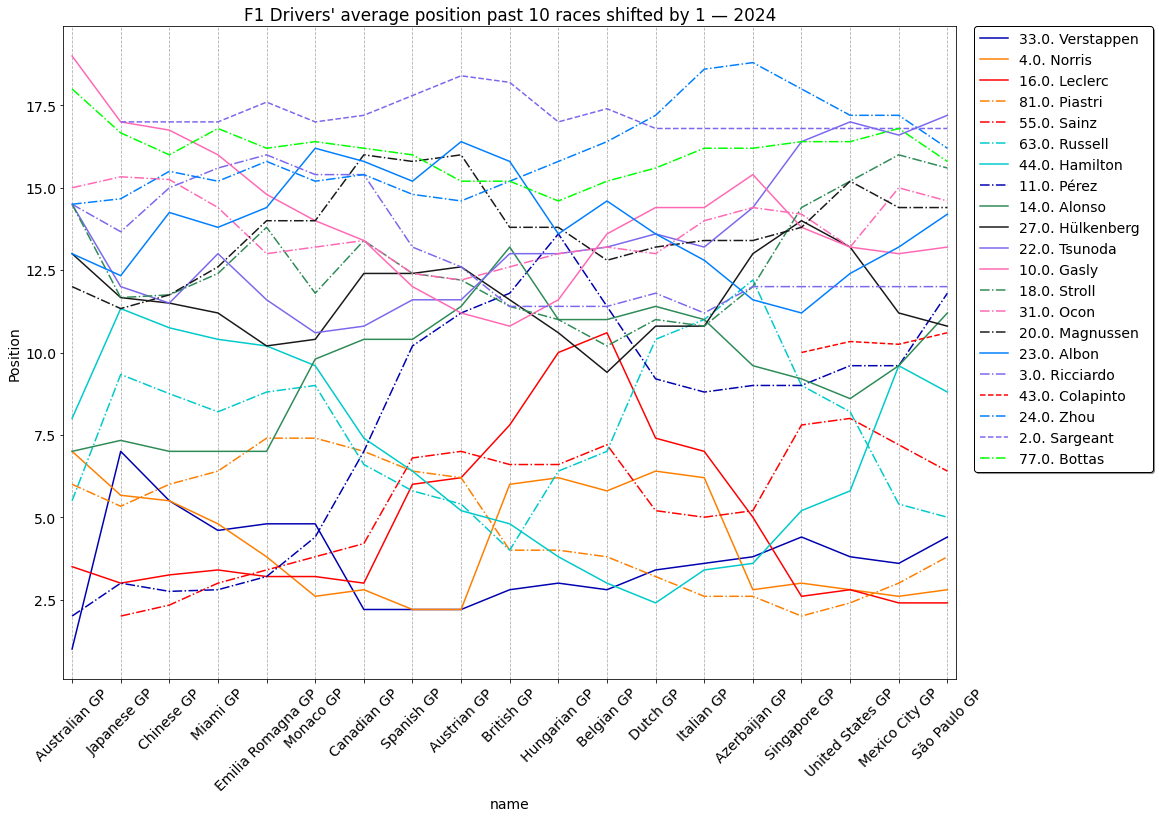

In [26]:
wide_format_races_ordered.plot(title=f"F1 Drivers\' average position past 10 races shifted by 1 — {YEAR}", color=color, style=style)
plt.xticks(range(wide_format_races_ordered.shape[0]), wide_format_races_ordered.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Position")
legend_opts = dict(bbox_to_anchor=(1.02, 0, 0.2, 1),
                   loc="upper right",
                   ncol=1,
                   shadow=True,
                   edgecolor="black",
                   mode="expand",
                   borderaxespad=0.)
plt.legend(**legend_opts)

# Ordinary Least Squares 

Neem het gemiddelde van de laatste 5 races, het resultaat van vorig jaar, en bereken de beta-coefficienten die de OLS oplossing geven voor het voorspellen van de komende race.

In [39]:
# Step 1: Calculate the 10-race and 5-race rolling averages excluding the current race
season_2024_results_sorted['avg_past_10_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
)
season_2024_results_sorted['avg_past_5_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Step 2: Rank drivers based on both rolling averages to get predicted rankings
predicted_ranks_10 = season_2024_results_sorted.pivot_table(index='raceId', columns='driverId', values='avg_past_10_races').rank(axis=1, method='min')
predicted_ranks_5 = season_2024_results_sorted.pivot_table(index='raceId', columns='driverId', values='avg_past_5_races').rank(axis=1, method='min')

# Step 3: Extract the actual finishing positions and align with predictions
actual_positions = season_2024_results_sorted.pivot_table(index='raceId', columns='driverId', values='positionOrder')

# Step 4: Calculate MAE for each approach
common_races = predicted_ranks_10.index.intersection(actual_positions.index)  # Align races
mae_10_race = (np.abs(predicted_ranks_10.loc[common_races] - actual_positions.loc[common_races])).mean().mean()
mae_5_race = (np.abs(predicted_ranks_5.loc[common_races] - actual_positions.loc[common_races])).mean().mean()

# Display the results
print(f"Mean Absolute Error (MAE) using 10-race average: {mae_10_race}")
print(f"Mean Absolute Error (MAE) using 5-race average: {mae_5_race}")

Mean Absolute Error (MAE) using 10-race average: 3.6429440872165326
Mean Absolute Error (MAE) using 5-race average: 3.6470105028457427


In [40]:
races_2023

Empty DataFrame
Columns: [raceId, name]
Index: []

In [41]:

import statsmodels.api as sm

# Step 1: Calculate the rolling average of the past 5 races, excluding the current race
def calculate_rolling_mean_excluding_current(group, window):
    return group.shift(1).rolling(window=window, min_periods=1).mean()

# Assuming 'season_2024_results_sorted' is sorted by race and contains 'positionOrder' for each driver
season_2024_results_sorted['avg_past_5_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(calculate_rolling_mean_excluding_current,window=5)
season_2024_results_sorted['avg_past_10_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(calculate_rolling_mean_excluding_current,window=10)

# Step 2: Get last year's race result for each driver for the same race
# Merge 2023 and 2024 race results to get last year's result for each race in 2024
last_year = 2023
current_year = 2024
races_2023 = races[races['year'] == last_year].reset_index()[['raceId', 'name']]
races_2024 = races[races['year'] == current_year].reset_index()[['raceId', 'name']]

# Merge on race names to align 2023 and 2024 race IDs
races_merged = pd.merge(races_2023, races_2024, on='name', suffixes=('_2023', '_2024'))

# Get results for 2023 and 2024
results_2023 = results[results['raceId'].isin(races_merged['raceId_2023'])]
id_dict = dict(races_merged[['raceId_2023','raceId_2024']].values)
results_2023.raceId = results_2023.raceId.map(id_dict)
results_2024 = season_2024_results_sorted

# Rename columns for merging
results_2023 = results_2023.rename(columns={'position': 'last_year_result'})
results_merged = pd.merge(
    results_2024,
    results_2023[['driverId', 'raceId', 'last_year_result']],
    left_on=['driverId', 'raceId'],
    right_on=['driverId', 'raceId'],
    how='left'
)

# Step 3: Create a wide-format DataFrame with avg_past_5_races and last_year_result for each driver and each race
driver_columns = results_merged[['driverId', 'raceId', 'avg_past_5_races', 'avg_past_10_races','last_year_result']]
wide_format = driver_columns.pivot_table(index='raceId', columns='driverId', values=['avg_past_5_races', 'avg_past_10_races','last_year_result'])

# Step 4: Reshape into long format with one row per race and columns avg_past_5_races and last_year_result
long_format = pd.melt(wide_format.reset_index(), id_vars=['raceId'], var_name=['metric', 'driverId'])

# Step 5: Add the current year's race result to the long format DataFrame
results_current_year = results_merged[['raceId', 'driverId', 'positionOrder']]
results_current_year = results_current_year.rename(columns={'positionOrder': 'this_year_result'})

long_format = pd.merge(long_format, results_current_year, on=['raceId', 'driverId'])

# Step 6: Filter only avg_past_5_races and last_year_result rows, pivot to get predictors in columns
long_format = long_format.pivot(index=['raceId', 'driverId'], columns='metric', values='value').reset_index()
long_format = pd.merge(long_format, results_current_year, on=['raceId', 'driverId'])
long_format = long_format.dropna(axis=0)
# Perform Ordinary Least Squares (OLS) regression
X = long_format[['avg_past_5_races', 'avg_past_10_races','last_year_result']]
X = sm.add_constant(X)  # Adds the intercept term (beta_0)
y = long_format['this_year_result']

# Fit the model
model = sm.OLS(y, X).fit()

# Output the summary of the OLS regression
print(model.summary())


C:\Users\tostraml\AppData\Local\Temp\ipykernel_936\951281096.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2023.raceId = results_2023.raceId.map(id_dict)
C:\Users\tostraml\Anaconda3\envs\dash\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


                            OLS Regression Results                            
Dep. Variable:       this_year_result   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     72.80
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           5.55e-35
Time:                        10:13:29   Log-Likelihood:                -833.86
No. Observations:                 289   AIC:                             1676.
Df Residuals:                     285   BIC:                             1690.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.4819      0.63

In [42]:
long_format = long_format.merge(races_2024[['raceId','name']])
long_format = long_format.merge(drivers.reset_index()[['driverId','number','surname']])
long_format['driver_label'] = long_format.number.astype(str) + ' ' + long_format.surname

In [43]:
import numpy as np

# Use the trained model to get the beta values
beta_0 = model.params['const']
beta_1 = model.params['avg_past_5_races']
beta_2 = model.params['avg_past_10_races']
beta_3 = model.params['last_year_result']

# Step 1: Calculate predictions using the beta values
long_format['predicted_result'] = (
    beta_0 + beta_1 * long_format['avg_past_5_races'] + beta_2 * long_format['avg_past_10_races'] + beta_3 * long_format['last_year_result']
)

# Step 2: Calculate the error between predicted and actual results
long_format['error'] = np.abs(long_format['predicted_result'] - long_format['this_year_result'])

# Step 3: Calculate Mean Absolute Error (MAE) as an indicator of performance
mae = long_format['error'].mean()

# Print the Mean Absolute Error for predictions
print(f"Mean Absolute Error (MAE) for predictions on races so far: {mae}")

# Optional: View prediction performance per race
per_race_performance = long_format.groupby('name')['error'].mean()
print("Mean Absolute Error (MAE) per race:")
print(per_race_performance)


Mean Absolute Error (MAE) for predictions on races so far: 3.3058787153971254
Mean Absolute Error (MAE) per race:
name
Australian Grand Prix       4.580989
Austrian Grand Prix         3.994688
Azerbaijan Grand Prix       4.444619
Belgian Grand Prix          2.917147
British Grand Prix          4.582905
Canadian Grand Prix         4.532121
Dutch Grand Prix            2.597879
Hungarian Grand Prix        2.101713
Italian Grand Prix          2.793354
Japanese Grand Prix         1.810806
Mexico City Grand Prix      2.902150
Miami Grand Prix            2.877505
Monaco Grand Prix           3.757658
Saudi Arabian Grand Prix    2.563173
Singapore Grand Prix        3.012943
Spanish Grand Prix          2.420745
São Paulo Grand Prix        5.582119
United States Grand Prix    2.354232
Name: error, dtype: float64


In [44]:
per_race_performance = long_format.groupby('driver_label')['error'].mean()
print("Mean Absolute Error (MAE) per driver:")
print(per_race_performance.sort_values(ascending=False))


Mean Absolute Error (MAE) per driver:
driver_label
63.0 Russell       4.192045
16.0 Leclerc       4.141897
18.0 Stroll        4.080578
22.0 Tsunoda       4.037975
23.0 Albon         3.936122
55.0 Sainz         3.879125
4.0 Norris         3.508602
27.0 Hülkenberg    3.465535
11.0 Pérez         3.364922
81.0 Piastri       3.364073
20.0 Magnussen     3.298398
44.0 Hamilton      3.242382
10.0 Gasly         3.186325
33.0 Verstappen    2.920041
2.0 Sargeant       2.875930
31.0 Ocon          2.848047
14.0 Alonso        2.581227
24.0 Zhou          2.517561
3.0 Ricciardo      1.522786
77.0 Bottas        1.459920
Name: error, dtype: float64


In [45]:

# Step 1: Calculate avg_past_5_races for each driver
season_2024_results_sorted['avg_past_5_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

season_2024_results_sorted['avg_past_10_races'] = season_2024_results_sorted.groupby('driverId')['positionOrder'].apply(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
)


# Get the last available avg_past_5_races for each driver up to the most recent race
avg_past_5_all_drivers = season_2024_results_sorted.dropna(subset=['avg_past_5_races','avg_past_10_races']).groupby('driverId')[['avg_past_5_races','avg_past_10_races']].last().reset_index()

# Step 2: Retrieve last year’s result for Brazil (raceId from 2023)
brazil_2023_race_name = "Las Vegas Grand Prix"
brazil_2023_raceId = races[(races['name'] == brazil_2023_race_name) & (races['year'] == 2023)].reset_index()['raceId'].values[0]
last_year_results_brazil = results[results['raceId'] == brazil_2023_raceId][['driverId', 'positionOrder']]
last_year_results_brazil = last_year_results_brazil.rename(columns={'positionOrder': 'last_year_result'})

# Step 3: Merge avg_past_5_races with last year's Brazil results for each driver
predictors_brazil = pd.merge(avg_past_5_all_drivers, last_year_results_brazil, on='driverId', how='inner')
predictors_brazil['predicted_result'] = (
    beta_0 + beta_1 * predictors_brazil['avg_past_5_races'] + beta_2 * predictors_brazil['avg_past_10_races']+ beta_3 * predictors_brazil['last_year_result']
)

predictors_brazil['predicted_rank'] = predictors_brazil['predicted_result'].rank()

# Sort by predicted rank to get final rankings for Brazil
predicted_rankings_brazil = predictors_brazil.sort_values('predicted_rank')

# Merge with driver names for readability
predicted_rankings_brazil = pd.merge(predicted_rankings_brazil, drivers.reset_index()[['driverId','number', 'surname']], on='driverId')


# Create the label in the format "number. surname"
predicted_rankings_brazil['driver_label'] = predicted_rankings_brazil['number'].astype(str) + ". " + predicted_rankings_brazil['surname']
predicted_rankings_brazil = predicted_rankings_brazil[~predicted_rankings_brazil.driver_label.str.contains('Ricciardo')]

# Select and sort by predicted rank with the new driver label
predicted_rankings_brazil_final = predicted_rankings_brazil.set_index('predicted_rank').sort_index()
predicted_rankings_brazil_final[['driver_label', 'avg_past_5_races','avg_past_10_races','last_year_result', 'predicted_result']]

driver_label  avg_past_5_races  avg_past_10_races  \
predicted_rank                                                          
1.0                16.0. Leclerc               2.4                4.7   
2.0             33.0. Verstappen               4.4                4.0   
3.0                81.0. Piastri               3.8                3.2   
4.0                  55.0. Sainz               6.4                5.7   
5.0                  4.0. Norris               2.8                4.5   
6.0                63.0. Russell               5.0                8.0   
7.0               44.0. Hamilton               8.8                6.1   
8.0                  11.0. Pérez              11.8               10.3   
9.0                 14.0. Alonso              11.2               11.1   
11.0            27.0. Hülkenberg              10.8               10.8   
12.0                  31.0. Ocon              14.6               14.3   
13.0                18.0. Stroll              15.6               13.2   
14.0                 10.0. Gasly              13.2               13.8   
15.0                 23.0. Albon              14.2               13.5   
16.0             20.0. Magnussen              14.4               13.6   
17.0                77.0. Bottas              15.8               16.0   
18.0                  24.0. Zhou              16.2               17.4   
19.0               22.0. Tsunoda              17.2               15.2   
20.0               2.0. Sargeant              16.8               17.3   

                last_year_result  predicted_result  
predicted_rank                                      
1.0                            2          4.313107  
2.0                            1          4.560638  
3.0                           10          5.555716  
4.0                            6          6.667076  
5.0                           20          7.343077  
6.0                            8          7.363748  
7.0                            7          7.776089  
8.0                            3          9.636313  
9.0                            9         10.715972  
11.0                          19         12.123684  
12.0                           4         12.182284  
13.0                           5         12.281866  
14.0                          11         12.689699  
15.0                          12         13.079006  
16.0                          13         13.346777  
17.0                          17         15.341970  
18.0                          15         15.652275  
19.0                          18         15.683398  
20.0                          16         15.980814

driverId  avg_past_5_races  last_year_result  predicted_result  \
0          1               9.6                 8          9.435901   
1          4               9.6                 3          8.546721   
2        807              11.2                12         11.233000   
3        815               9.6                 4          8.724557   
4        817              12.0                13         11.953713   
5        822              16.8                16         15.744482   
6        825              14.4                18         14.471524   
7        830               3.6                 1          4.119471   
8        832               7.2                 6          7.451598   
9        839              15.0                10         13.455993   
10       840              16.0                 5         13.245408   
11       842              13.0                 7         11.565292   
12       844               2.4                20          6.684043   
13       846               2.6                 2          3.618711   
14       847               5.4                15          7.830650   
15       848              13.2                19         13.835045   
16       852              16.6                 9         14.363910   
17       855              17.2                17         16.193757   
18       857               3.0                14          6.024183   
19       858              16.8                11         14.855302   

    predicted_rank  
0              9.0  
1              7.0  
2             10.0  
3              8.0  
4             12.0  
5             19.0  
6             17.0  
7              2.0  
8              5.0  
9             14.0  
10            13.0  
11            11.0  
12             4.0  
13             1.0  
14             6.0  
15            15.0  
16            16.0  
17            20.0  
18             3.0  
19            18.0

In [14]:
print(f'Average of past 7 races per {chart.index[-1]}')
chart.iloc[-1].sort_values(ascending=False)

Average of past 7 races per Mexico City GP


3. Leclerc        19.80
2. Norris         18.00
4. Piastri        14.40
5. Sainz          13.60
1. Verstappen     13.40
7. Russell        11.00
6. Hamilton        7.00
9. Alonso          2.40
8. Pérez           2.20
10. Hülkenberg     1.80
13. Magnussen      1.80
14. Albon          1.60
18. Colapinto      1.25
17. Bearman        0.20
16. Gasly          0.20
11. Stroll         0.00
19. Ocon           0.00
23. Bottas         0.00
12. Tsunoda        0.00
21. Zhou           0.00
15. Ricciardo      0.00
22. Sargeant       0.00
20. Lawson         0.00
Name: Mexico City GP, dtype: float64

In [15]:
races['raceKey']

raceId
1121    202401
1122    202402
1123    202403
1124    202404
1125    202405
1126    202406
1127    202407
1128    202408
1129    202409
1130    202410
1131    202411
1132    202412
1133    202413
1134    202414
1135    202415
1136    202416
1137    202417
1138    202418
1139    202419
1140    202420
1141    202421
1142    202422
1143    202423
1144    202424
Name: raceKey, dtype: int64


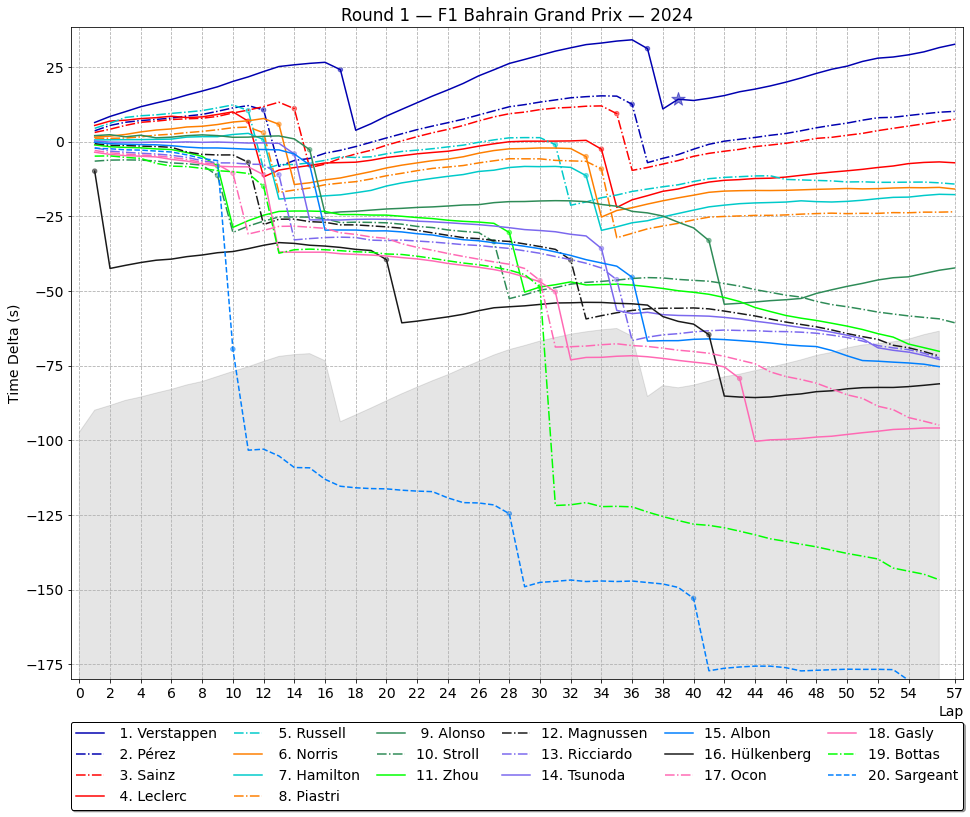


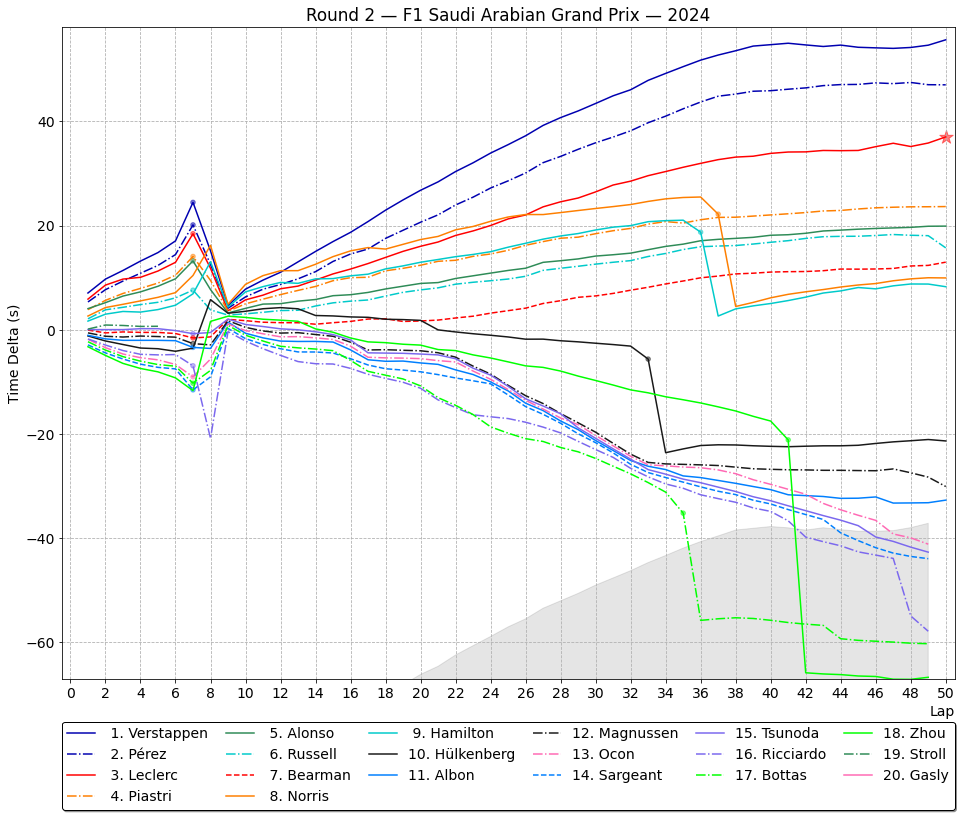


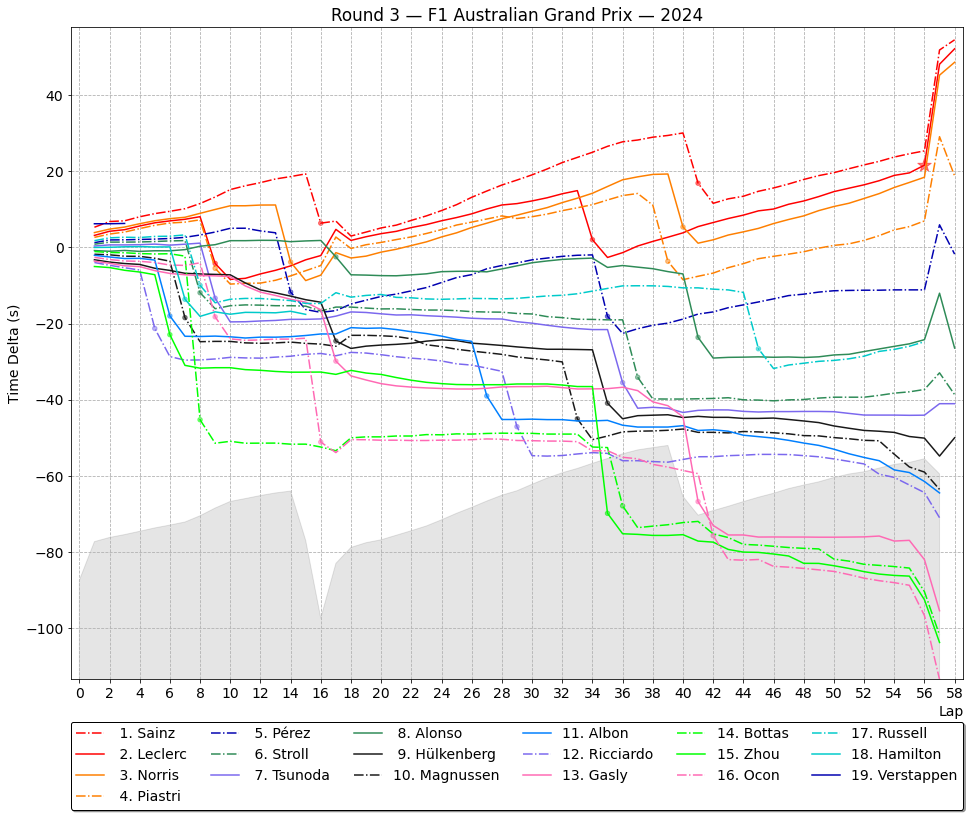


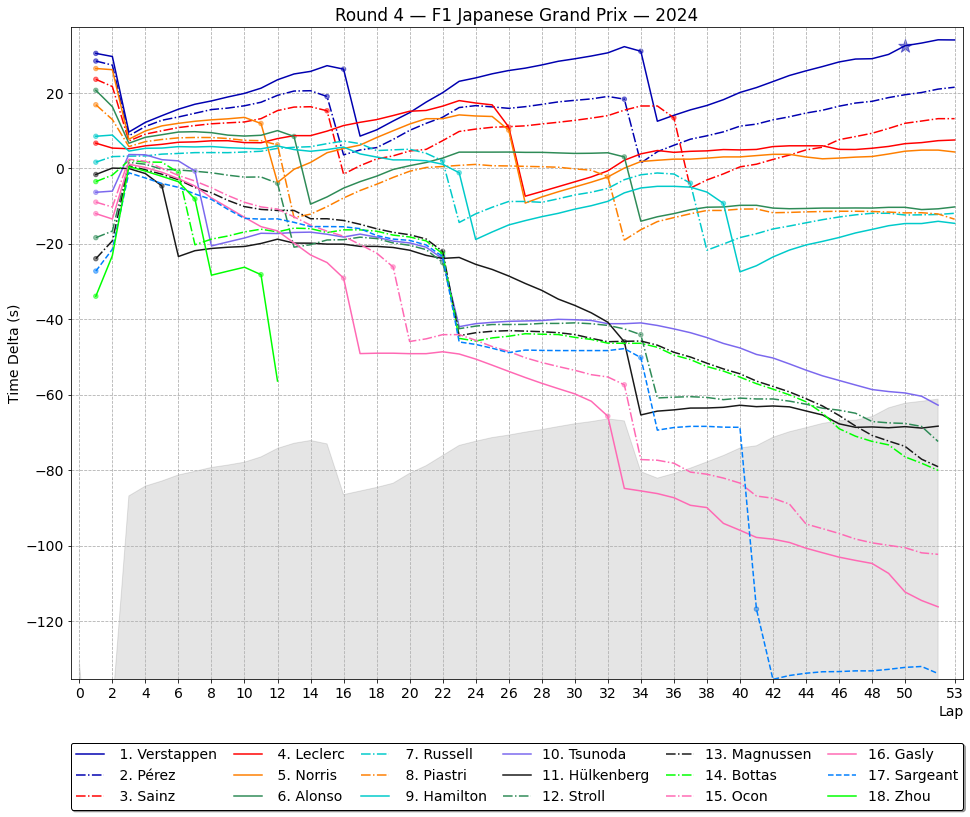


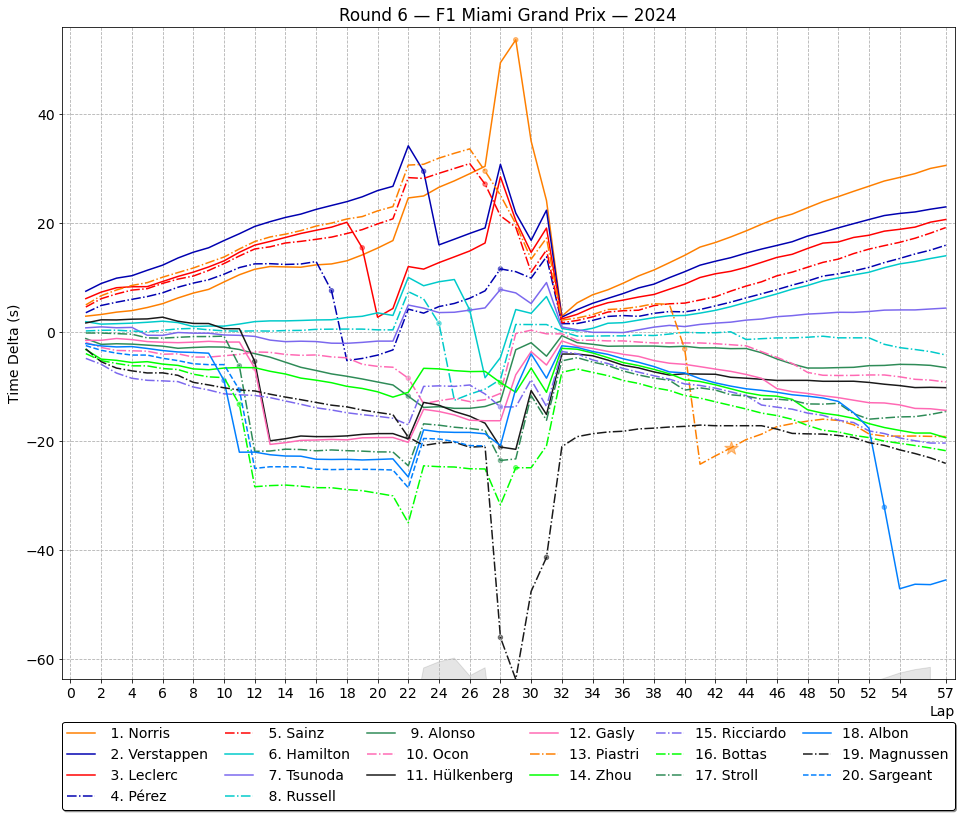


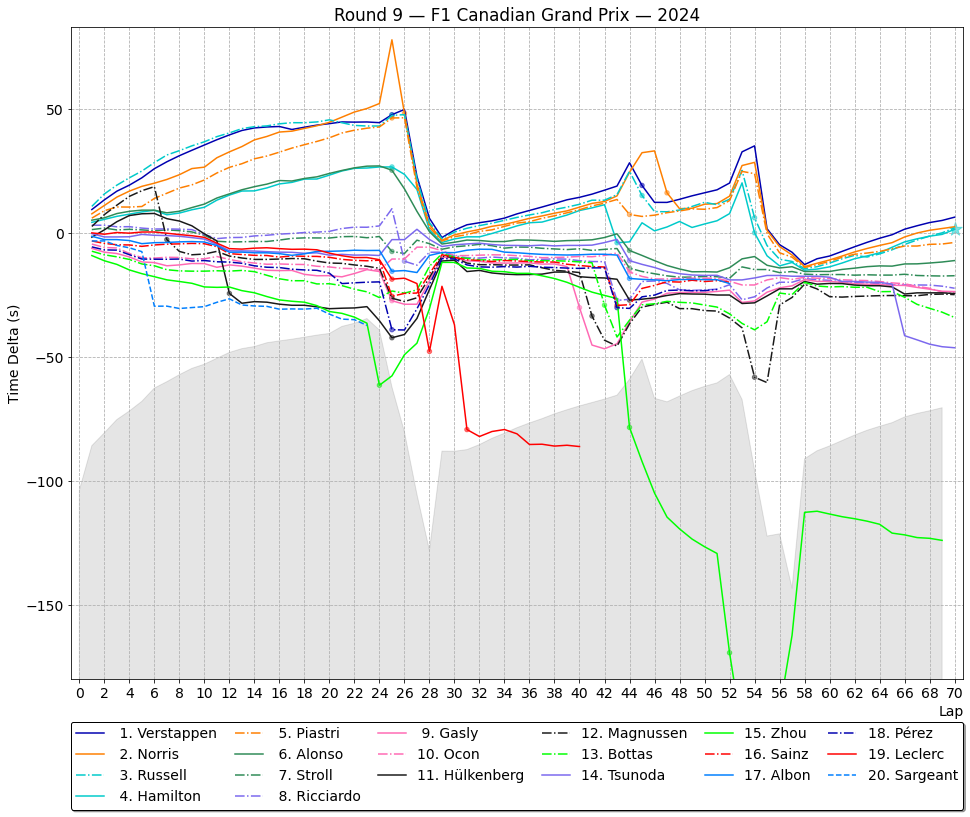


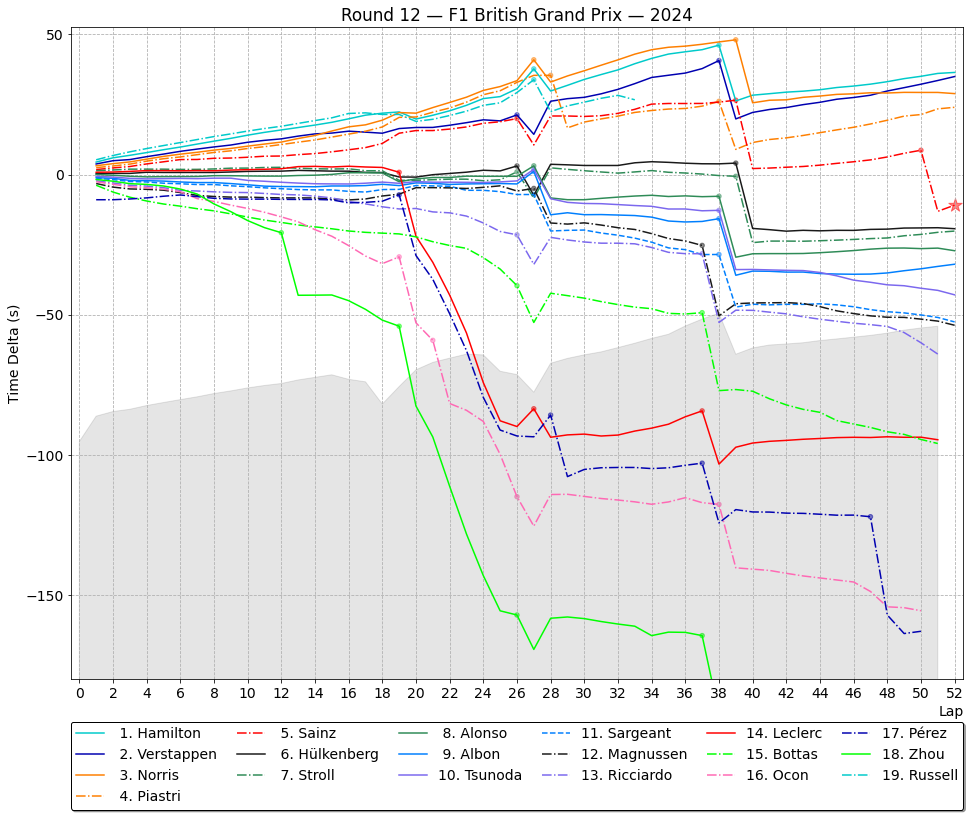


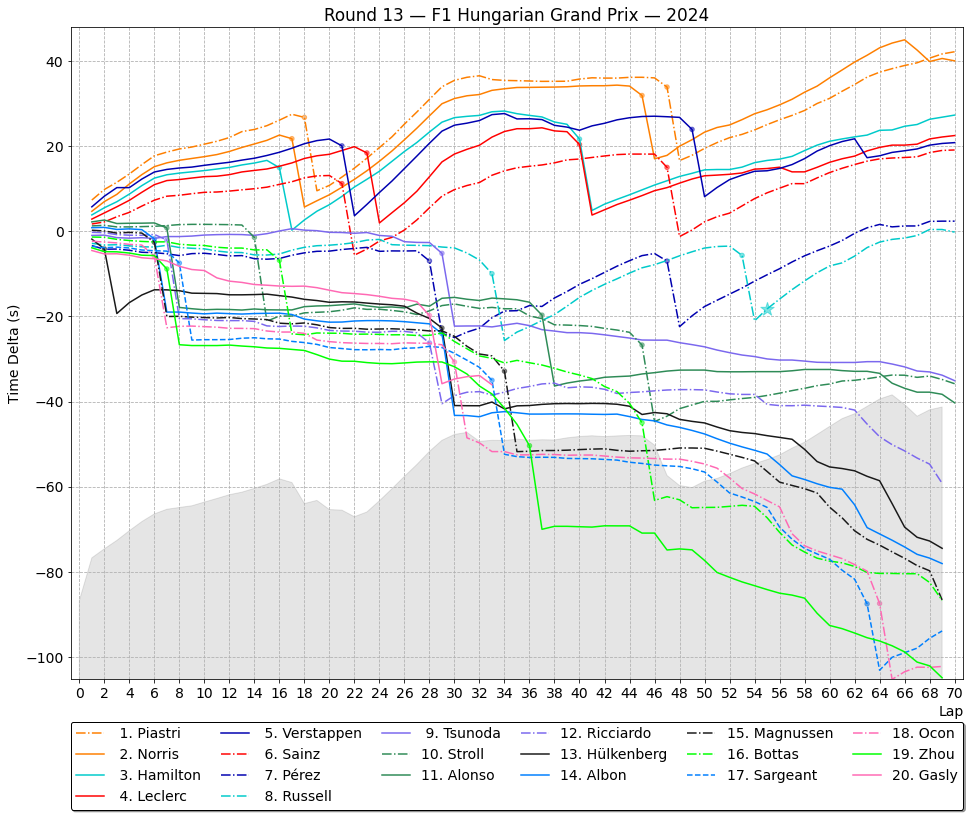


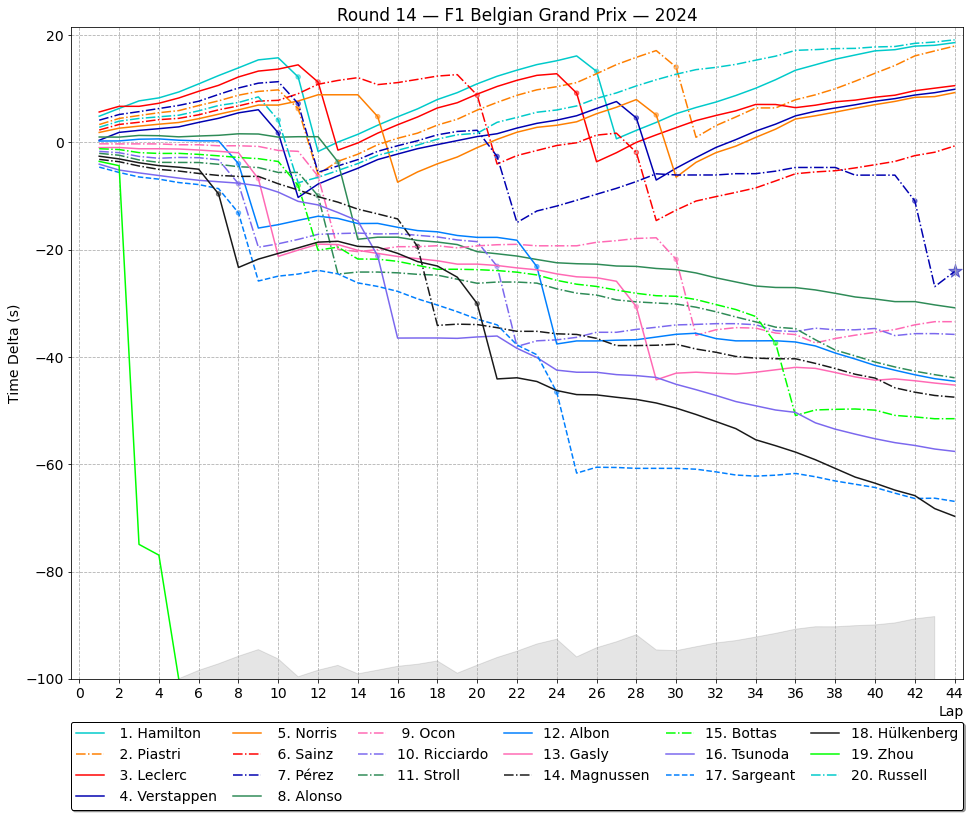


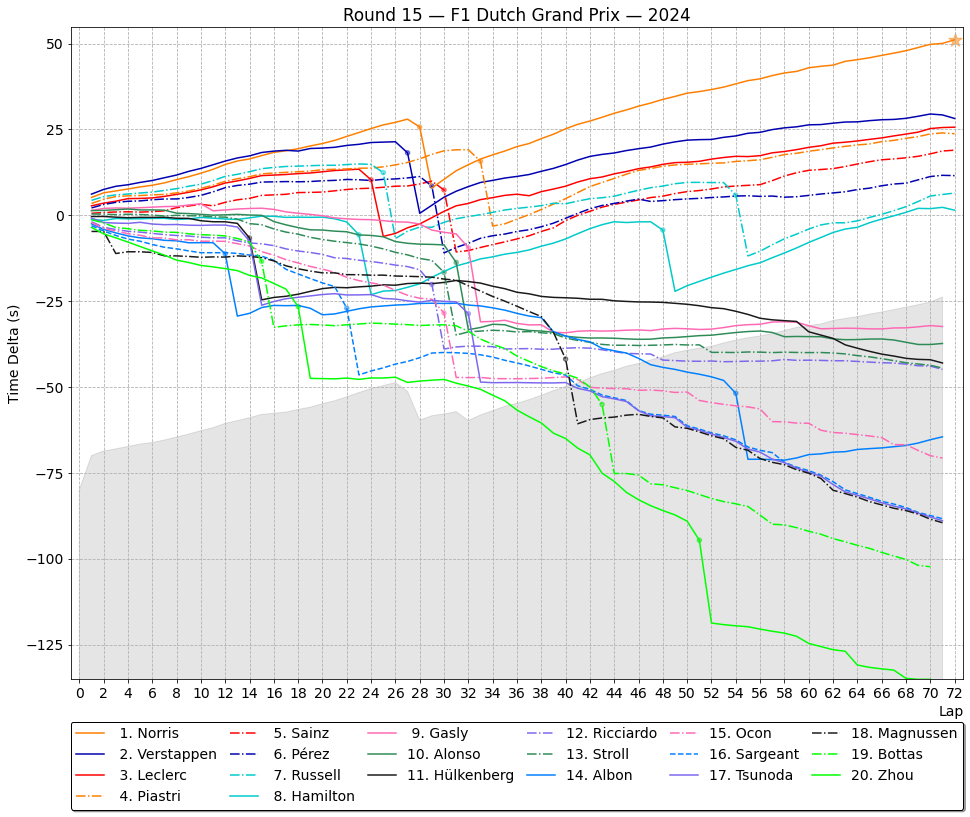


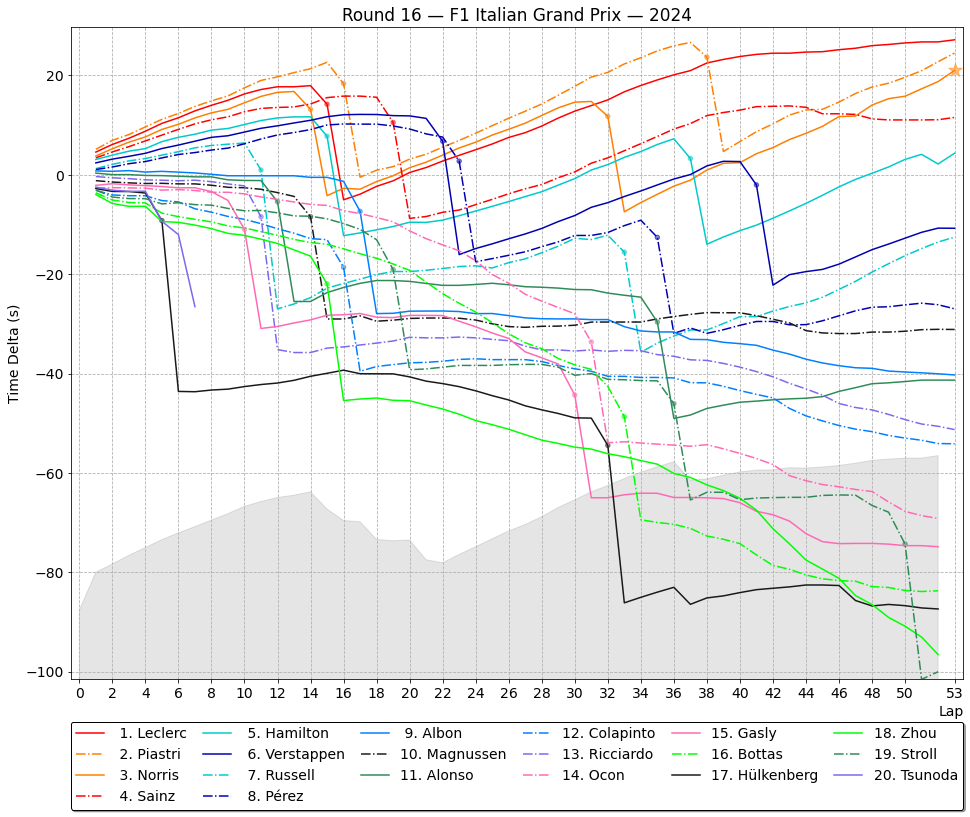


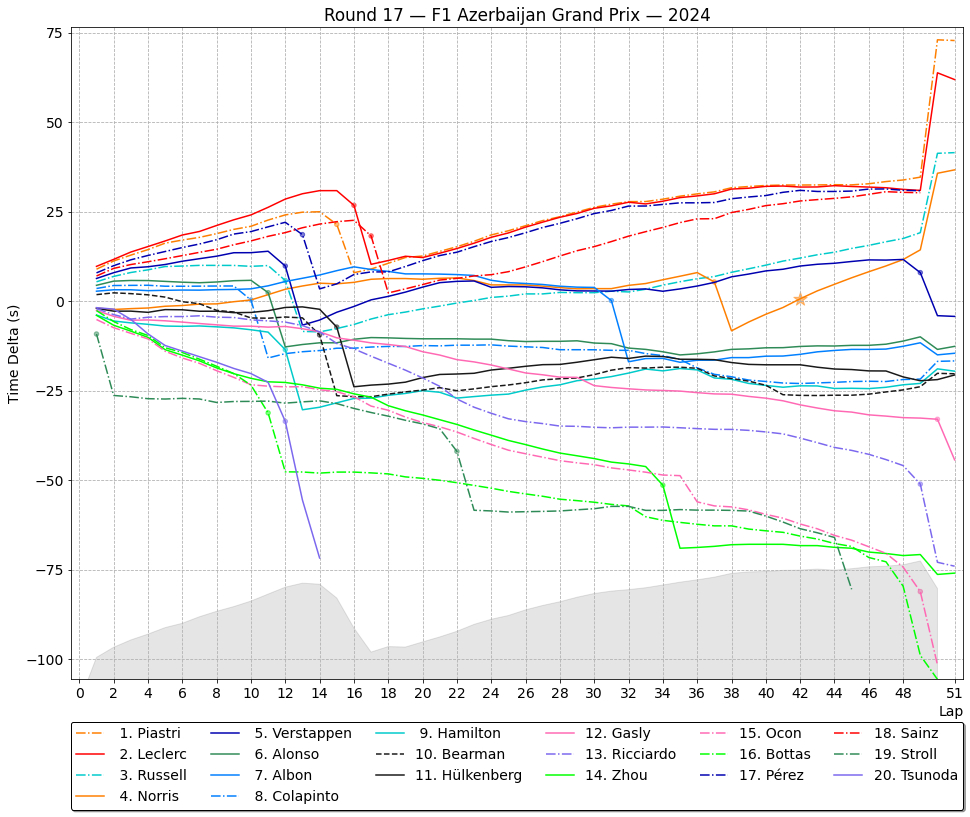


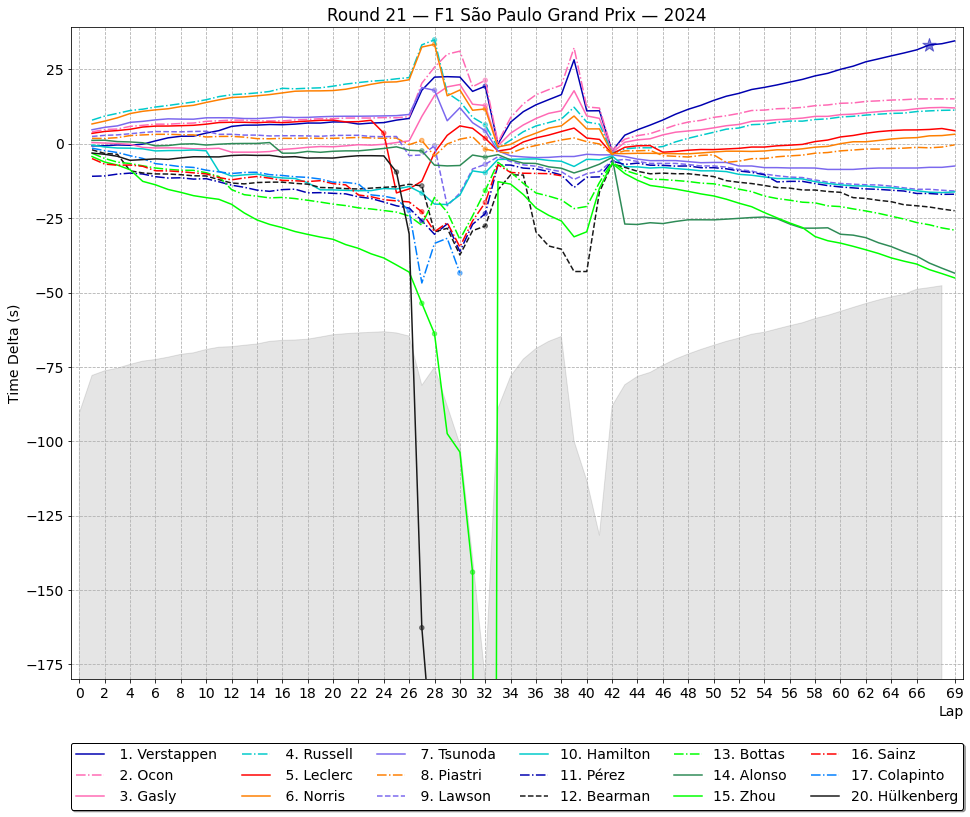


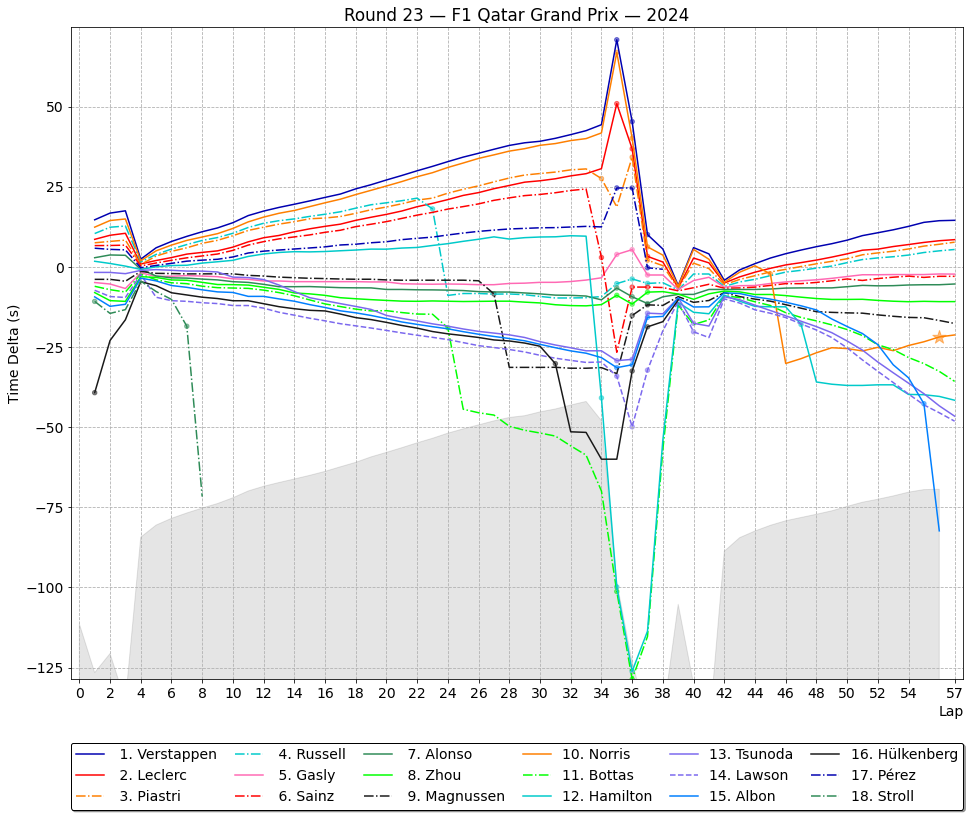

In [25]:
# Show race traces
NEGATIVE_CUTOFF = -180
ANNOTATION_FONT_DICT = {"fontstyle":"italic", "fontsize":14}

def create_img_html(url, alt, style="display: inline-block;", width=16, height=16):
    return f'<img src="{url}" alt="{alt}" style="{style}" width="{width}" height="{height}">'

# Icons with their respective URLs
YT_IMG = create_img_html("https://youtube.com/favicon.ico", alt="YouTube icon")
WK_IMG = create_img_html("https://wikipedia.org/favicon.ico", alt="Wikipedia icon")
GM_IMG = create_img_html("https://maps.google.com/favicon.ico", alt="Google Maps icon")

fastest_laps = Counter()

def header_html_lines(race):

    circuit = circuits.loc[race.circuitId]
    qstr = race["name"].replace(" ", "+")
    map_url = "https://www.google.com/maps/search/{lat}+{lng}".format(**circuit)
    vid_url = f"https://www.youtube.com/results?search_query=f1+{YEAR}+{qstr}"

    return [
        '<h2 id="race{round}">R{round} — {name}</h2>'.format(**race),
        f'[ <a href=#race{race["round"]-1}>&larr; prev</a> ]' if race['round'] > 1 else '',
        f'[ <a href=#race{race["round"]+1}>next &rarr;</a> ]' if race['round'] < len(races) else '',
        '<p><b>{date}</b> — '.format(img=WK_IMG, **race),
        '<b>Circuit:</b> <a href="{url}">{name}</a>, {location}, {country}'.format(**circuit),
        '<br><a href="{url}">{img} Wikipedia race report</a>'.format(img=WK_IMG, **race),
        f'<br><a href="{map_url}">{GM_IMG} Map Search</a>',
        f'<br><a href="{vid_url}">{YT_IMG} YouTube Search</a>',
    ]


for race_key, times in lapTimes.groupby(lapTimes.raceId.map(races["raceKey"])):

    race = races.loc[races.raceKey==race_key].squeeze()
    fullname = str(race["year"]) + " " + race["name"]
    title = "Round {round} — F1 {name} — {year}".format(**race)
    
    res = results.loc[results.raceId==race.name].set_index("driverId")
    res = res.join(drivers.drop(labels="number", axis=1))

    # Lap time data: One row per lap, one column per driver, values are lap time in seconds
    chart = times.pivot_table(values="seconds", index="lap", columns="driverId")

    annotation = ""


    # Re-order columns by race finish position for the legend
    labels = res.loc[chart.columns].apply(lambda r: "{positionOrder:2.0f}. {display}".format(**r), axis=1)
    order = np.argsort(labels)
    show = chart.iloc[:, order]

    basis = chart.median(axis=1).cumsum() # reference laptime series
    frontier = chart.cumsum().min(axis=1) # running best cumulative time

    # A red flag stoppage will create very long lap-times.
    # If this is late in the race & the cars are on different laps
    # (i.e. some are 1,2 or 3 laps down) the median time may be low for all those laps.
    # This means the overall median does not adjust the cumulative times enough,
    # this code corrects for that... e.g. Monaco 2011
    if any((frontier-basis)>100):
        adjust = ((frontier-basis)>100) * (frontier-basis).max()
        basis = (chart.median(axis=1) + adjust.diff().fillna(0)).cumsum()
    
    # Subtract reference from cumulative lap times
    show = -show.cumsum().subtract(basis, axis=0)

    # Fix large outliers (again, due to red flags), e.g. Australia 2016
    show[show>=800] = np.nan

    # Pitstops
    stops = pitStops.loc[pitStops.raceId==race.name].copy()
    if len(stops):
        # Brazil 2014 has pitstop times for Kevin Magnussen but no laptimes!
        stops = stops[stops.driverId.isin(chart.columns)]
        # Find x,y points for pitstops
        # (pd.DataFrame.lookup could do this with 1 line but it's deprecated)
        col_ix = list(map(show.columns.get_loc, stops.driverId))
        row_ix = list(map(show.index.get_loc, stops.lap))
        stops_y = show.to_numpy()[row_ix, col_ix]

    fastest_lap = times.iloc[np.argmin(np.asarray(times.seconds))]
    fastest_lap_y = show.loc[fastest_lap.lap, fastest_lap.driverId]

    # Lookup team color for this race (e.g. Russell 2020 Sakhir = Mercedes)
    driver_colors = res.constructorId.map(TEAM_C).to_dict()
    color = [driver_colors[d] for d in show.columns]
    style = [LINESTYLES[DRIVER_LS[d]] for d in show.columns]
    show.columns = labels.values[order]

    # Main Plot
    show.plot(title=title, style=style, color=color)
    plt.scatter(fastest_lap.lap,
                fastest_lap_y,
                s=200,
                marker='*',
                c=driver_colors[fastest_lap.driverId],
                alpha=.5)

    if len(stops):
        plt.scatter(stops.lap,
                    stops_y,
                    s=20,
                    marker='o',
                    c=list(map(driver_colors.get, stops.driverId)),
                    alpha=.5)

    top = show.max(axis=1).max()
    bottom = max(NEGATIVE_CUTOFF, show.min(axis=1).min())
    span = (top-bottom)
    ymin = bottom
    ymax = top+(span/50)

    # Add the shadow of where the lead car is compared to previous lap
    leader_line = add_lap_0(show).max(axis=1)
    leader_times = add_lap_0(chart).cumsum().min(axis=1).diff().shift(-1)
    plt.fill_between(leader_times.index,
                     (leader_line-leader_times).clip(NEGATIVE_CUTOFF),
                     -1000,
                     color='k',
                     alpha=.1)
    
  

    # Finishing touches
    xticks = np.arange(0, len(chart)+1, 2)
    if len(chart) % 2:  # odd number of laps: nudge last tick to show it
        xticks[-1] += 1

    plt.xlabel("Lap", loc="right")
    plt.ylabel("Time Delta (s)")
    plt.xticks(xticks, xticks)
    plt.ylim(ymin, ymax)
    plt.grid(linestyle="--")
    plt.annotate(annotation, (10, -50), xycoords="axes pixels", **ANNOTATION_FONT_DICT);
    plt.legend(bbox_to_anchor=(0, -0.2, 1, 1),
               loc=(0, 0),
               ncol=6,
               shadow=True,
               edgecolor="black",
               mode="expand",
               borderaxespad=0.)

    fastest_laps[fastest_lap.driverId.squeeze()] += 1
    fastest_lap = fastest_lap.to_frame('').T.join(drivers, on='driverId')
    fastest_lap.columns = fastest_lap.columns.str.capitalize()

    html_lines = header_html_lines(race) + [
        render_plot('F1 {year} Round {round} — {name}'.format(**race),
                    'F1 {year} Round {round} — {name}'.format(**race)),
        table_html(fastest_lap[['Lap', 'Position', 'Time', 'Driver']], "Fastest Lap"),
        table_html(format_results(res), "Results")
    ]
    display(HTML("\n".join(html_lines)))

In [26]:
champ = driverStandings.groupby("driverId").position.last().to_frame("Pos")

champ = champ.sort_values("Pos").join(drivers)

results["win"] = (results["position"] == 1)
results["pole"] = (results["grid"] == 1)
results["top10"] = (results["grid"] <= 10)
results["dnf"] = results.position.isnull()

gb = results.groupby("driverId")

table = pd.DataFrame({
    "Laps": gb.laps.sum(),
    "Points": gb.points.sum(),
    "Wins": gb.win.sum(),
    "Podiums": gb.podium.sum(),
    "Scores": gb.score.sum(),
    "Poles": gb.pole.sum(),
    "Top 10 Starts": gb.top10.sum(),
    "Fastest Laps": fastest_laps,
    "Finishes": gb.position.count(),
    "DNFs": gb.dnf.sum()
})

if 'sprint_results' in globals():
    # From 2022 onwards sprint race points are separate,
    # and are *not* included in points for main race
    sprint_points = sprint_results.groupby("driverId").points.sum()
    if sprint_points.count():
        table["Points"] += sprint_points

table = table.fillna(0)
labels = champ.display + " (" + champ.Pos.astype(str) + ")"
data = table.reindex(champ.head(8).index)
data.index = data.index.map(labels)

In [27]:
data

Laps  Points  Wins  Podiums  Scores  Poles  Top 10 Starts  \
driverId                                                                    
Verstappen (1)  1389   399.0     9       14      23      8             22   
Norris (2)      1437   344.0     4       13      23      8             23   
Leclerc (3)     1413   327.0     3       13      21      3             21   
Piastri (4)     1444   265.0     2        8      23      0             23   
Sainz (5)       1343   262.0     2        9      20      1             22   
Russell (6)     1423   226.0     2        4      21      4             22   
Hamilton (7)    1346   207.0     2        5      21      0             18   
Pérez (8)       1264   138.0     0        4      16      0             15   

                Fastest Laps  Finishes  DNFs  
driverId                                      
Verstappen (1)           3.0        23     1  
Norris (2)               6.0        24     0  
Leclerc (3)              3.0        23     1  
Piastri (4)              1.0        24     0  
Sainz (5)                1.0        21     2  
Russell (6)              2.0        22     2  
Hamilton (7)             2.0        22     2  
Pérez (8)                1.0        20     4